In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
import copy
import random
import importlib
import algos as al
import imageio

In [73]:
def add_weights_to_edges_from_dict(graph, weights_dict):
    for edge, weight in weights_dict.items():
        if graph.has_edge(*edge):
            graph[edge[0]][edge[1]]['weight'] = weight
        elif graph.has_edge(*reversed(edge)):
            graph[reversed(edge)[0]][reversed(edge)[1]]['weight'] = weight
        else:
            print(f"Edge {edge} not found in the graph.")

In [5]:
def initialize_edge_weights(graph):
    """Set all edge weights to 0 for visualization."""
    for u, v in graph.edges():
        graph[u][v]['weight'] = 0

In [6]:
def get_highest_degree_node(graph):
    """Return the node with the highest degree in the graph."""
    degrees = dict(graph.degree())
    return max(degrees, key=degrees.get)

In [7]:
def multiple_probabilistic_walks(graph, num_walks, steps):
    walked_edges_per_step = [[] for _ in range(steps)]  # Store walked edges per step
    edge_step_count = {edge: 0 for edge in graph.edges()}  # Track how many times each edge is stepped on
    starting_node = get_highest_degree_node(graph)  # Start walks from the highest degree node
    pagerank_scores = nx.pagerank(graph)
    for _ in range(num_walks):
        current_node = starting_node
        
        for i in range(steps):
            neighbors = list(graph.neighbors(current_node))
            weights = [
                1/pagerank_scores[neighbor] + 0.000000001
                for neighbor in neighbors
            ]
    
            # Normalize probabilities
            total_weight = sum(weights)
            if total_weight == 0:
                print("Encountered zero total weight")
                break
            
            probabilities = [w / total_weight for w in weights]
    
            next_node = random.choices(neighbors, weights=probabilities)[0]
            edge = (min(current_node, next_node), max(current_node, next_node))

            walked_edges_per_step[i].append(edge)
            edge_step_count[edge] += 1  # Update step count for the edge


            current_node = next_node

    v_graph = copy.deepcopy(graph)
    print(v_graph)
    initialize_edge_weights(v_graph)
    snapshots = []
    for  edges_in_step in walked_edges_per_step:
        for edge in edges_in_step:
            u, v = edge
            v_graph[u][v]['weight'] += 1 
        snapshot = copy.deepcopy(v_graph)
        snapshots.append(snapshot)
        
    
    return snapshots 

In [67]:
def KMJ(v, f, i, min_edges, max_iter=1500):
    """
    Generates a planar scale-free graph using the KMJ method.
    
    v: Number of vertices
    f: Distribution function (callable)
    i: Number of iterations
    min_edges: Minimum number of edges before stopping
    """
    # Step 1: Create vertices
    G = nx.Graph()
    G.add_nodes_from(range(v))
    
    # Assign probabilities based on distribution function
    probabilities = f(v)
    probabilities /= probabilities.sum()  # Normalize to make it a probability distribution
    
    # Step 2: Add edges iteratively
    edge_count = 0
    iter = 0
    while ((iter <i or edge_count<min_edges or len(list(nx.connected_components(G)))>1)and iter<max_iter) :
        
        # Select first vertex based on probability distribution
        vertex1 = np.random.choice(range(v), p=probabilities)
        
        # Select second vertex purely randomly
        vertex2 = random.randint(0, v - 1)
        
        
        # Avoid self-loops
        if vertex1 == vertex2:
            continue
        
        # Add edge if planarity is preserved
        if (not G.has_edge(vertex1,vertex2)):            
            G.add_edge(vertex1, vertex2)
            
            if nx.check_planarity(G)[0]:  # Check if still planar
                edge_count += 1
            else:
                G.remove_edge(vertex1, vertex2)  # Revert if not planar
                
        iter+=1
    return G

In [68]:
import scipy.stats as stats
v = 50  # Number of vertices
i = 1500  # Max iterations
min_edges = 150  # Minimum edges before stopping

def normal_distribution(v, mu=None, sigma=None):
    """
    Creates a normal distribution centered around mu with standard deviation sigma.
    """
    if mu is None:
        mu = v / 2  # Center around the middle vertex
    if sigma is None:
        sigma = v / 4  # Control spread

    x = np.arange(v)
    probabilities = stats.norm.pdf(x, loc=mu, scale=sigma)  # Normal PDF values
    return probabilities

# Generate the graph
G = KMJ(v, normal_distribution, i, min_edges,3000)
print(len(G.edges))

141


In [69]:
def visualize_graph_pretty(G, title="Graph Visualization", seed=42):
    plt.figure(figsize=(18,8), facecolor='#5e5e5e')
    ax = plt.gca()
    ax.set_facecolor('#5e5e5e')
    pos = nx.spring_layout(G, weight=None, seed=seed)  # You can use other layouts as well

    # Check if edges have weights
    if nx.get_edge_attributes(G, 'weight'):
        # If weights exist, use them for edge coloring
        edge_weights = np.array([G[u][v].get('weight', 1) for u, v in G.edges()])
        cmap = plt.cm.plasma
        norm_weights = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min())
        min_alpha = 0.1  # Minimum alpha for visibility
        alphas = norm_weights * (1 - min_alpha) + min_alpha
        edge_colors = [cmap(weight) for weight in norm_weights]
        edge_colors_with_alpha = [(r, g, b, a) for (r, g, b, _), a in zip(edge_colors, alphas)] # Use weights for edge coloring
    else:
        # If no weights, set all edges to the same color (e.g., gray)
        edge_colors_with_alpha = 'blue'
        edge_weights = None  # No weights present

    # Draw edges
    nx.draw_networkx_edges(
        G,
        pos,
        arrowsize=10,
        edge_color=edge_colors_with_alpha,
        width=2,
    )

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=min(5000/G.number_of_nodes(), 200))
    
    # If edge weights exist, create colorbar based on scalar values (not RGBA tuples)
    if edge_weights is not None:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=edge_weights.min(), vmax=edge_weights.max()))
        sm.set_array([])  # Create an empty array for the ScalarMappable
        plt.colorbar(sm, label='Edge Weight', orientation='vertical', fraction=0.046, pad=0.04)
    
    plt.title(title)
    plt.show()

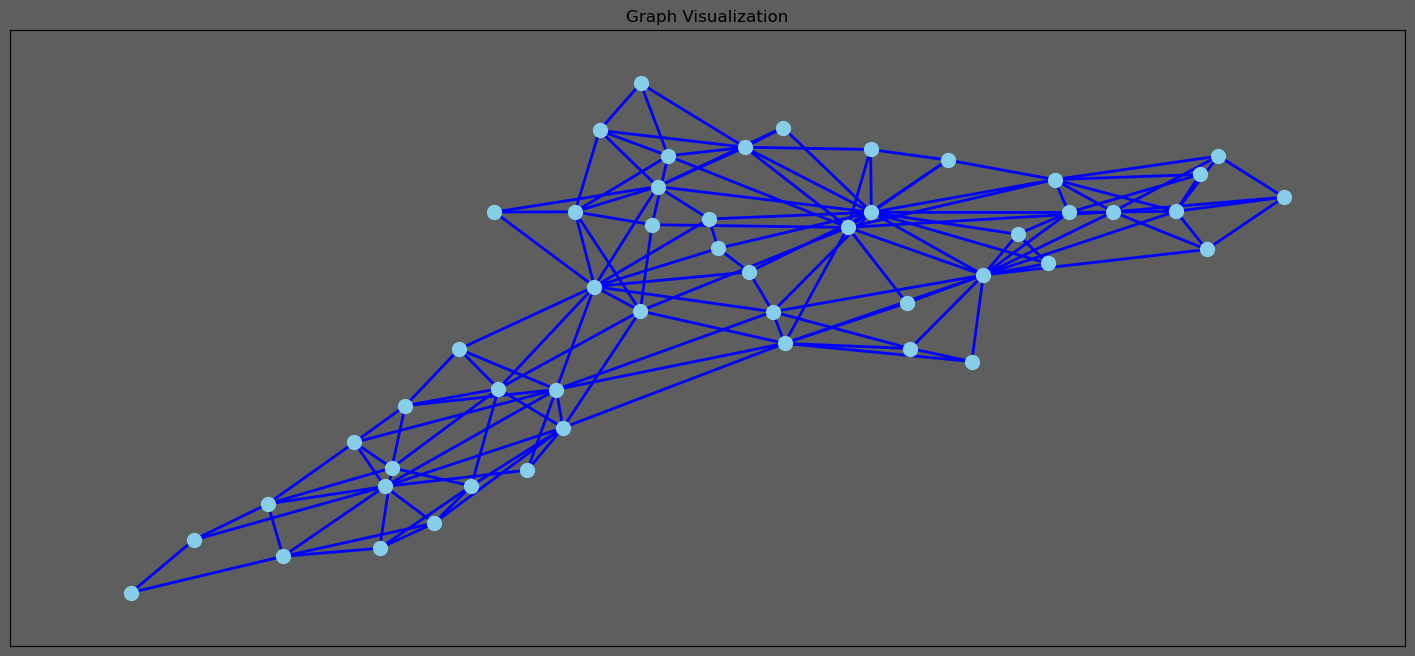

In [70]:
visualize_graph_pretty(G)

In [74]:
SF = copy.deepcopy(G)
PR = copy.deepcopy(G)
DR = copy.deepcopy(G)


add_weights_to_edges_from_dict(SF,nx.betweenness_centrality(nx.line_graph(SF)))
add_weights_to_edges_from_dict(DR,nx.degree_centrality(nx.line_graph(DR)))
add_weights_to_edges_from_dict(PR,nx.pagerank(nx.line_graph(SF),max_iter=500))


C:\Users\Kocsis Máté\AppData\Local\Temp\ipykernel_8808\2619976664.py:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Edge Weight', orientation='vertical', fraction=0.046, pad=0.04)


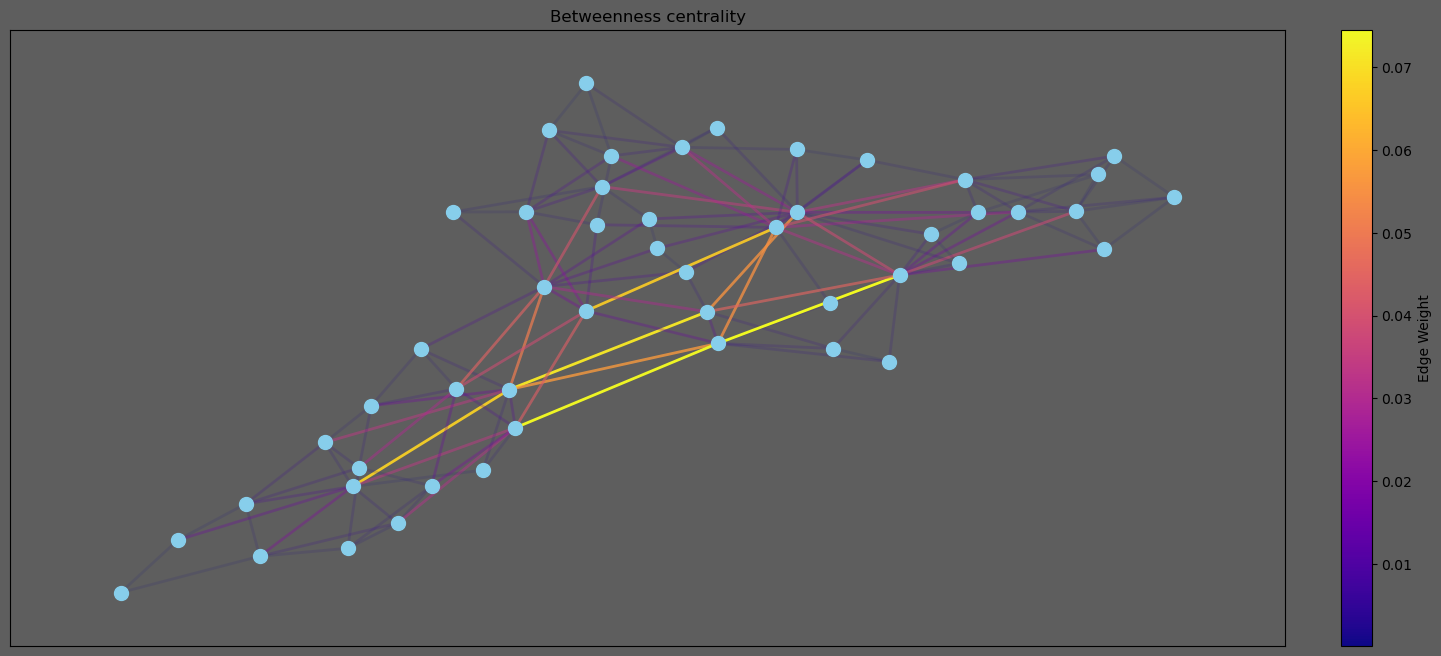

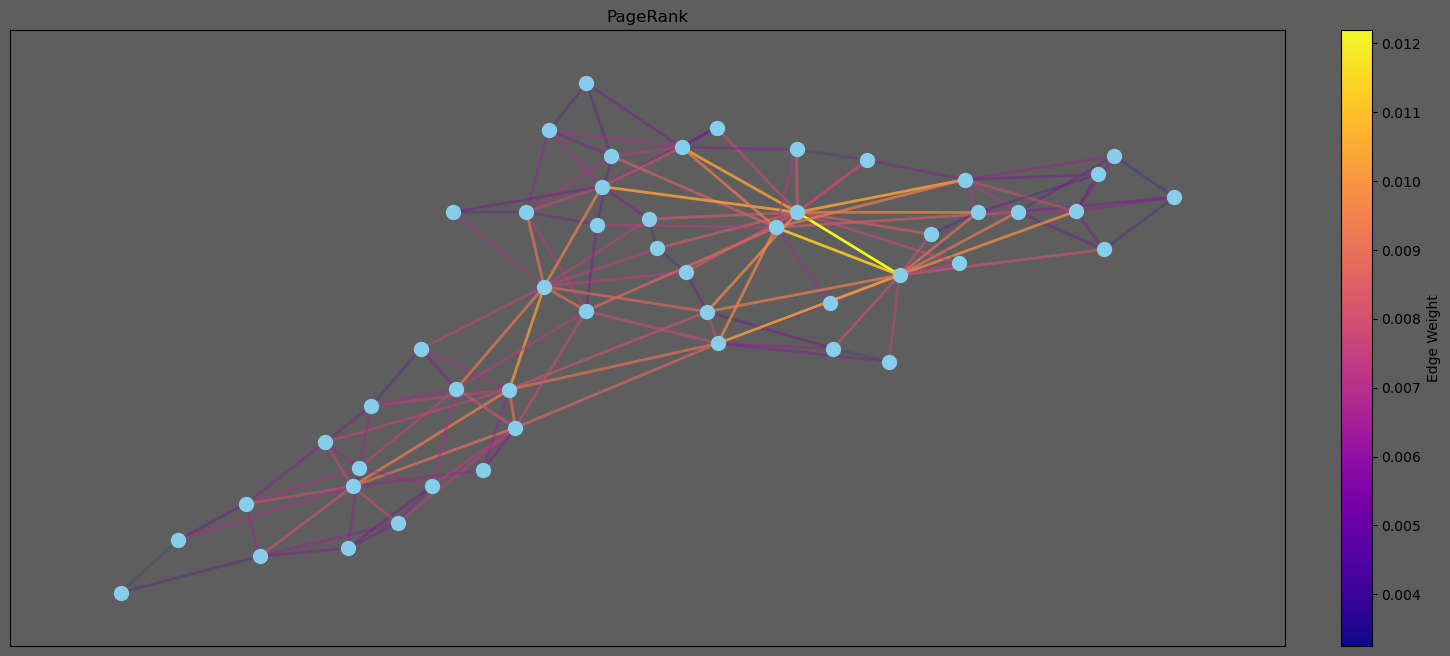

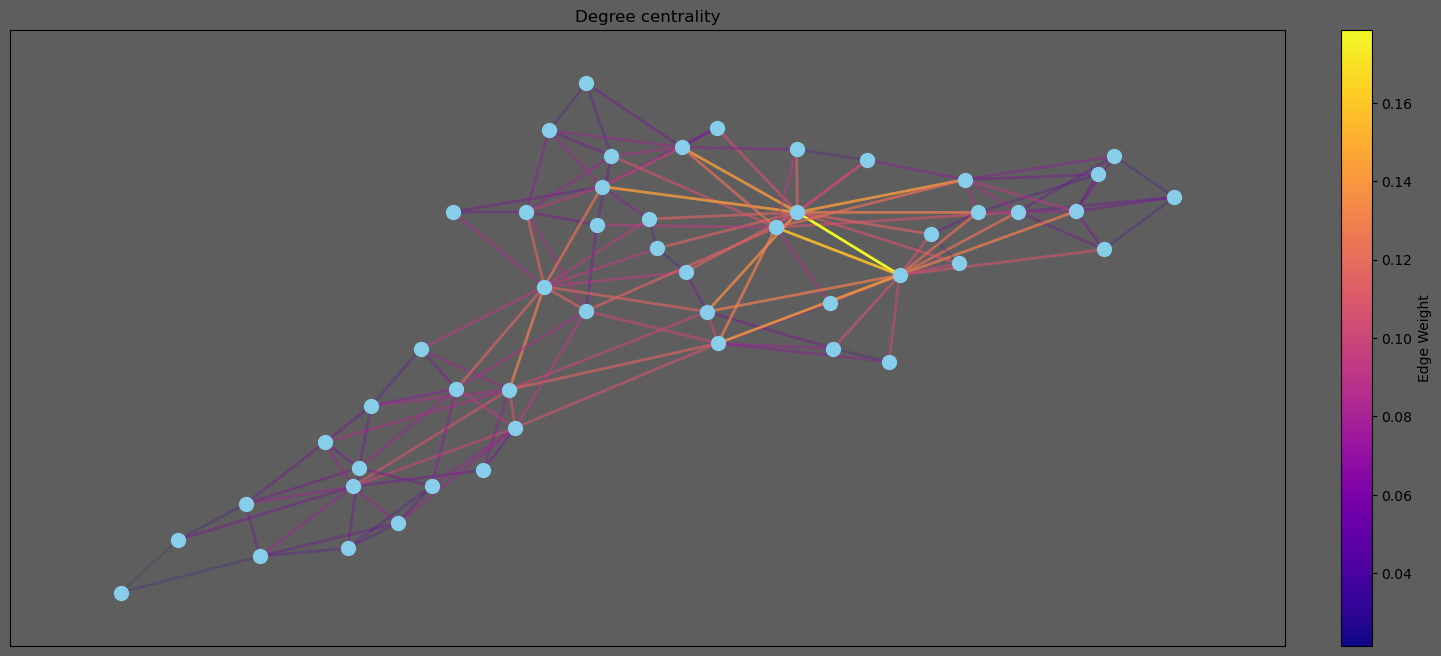

In [75]:
visualize_graph_pretty(SF, "Betweenness centrality")
visualize_graph_pretty(PR, "PageRank")
visualize_graph_pretty(DR, "Degree centrality")

In [76]:
def visualize_graph(snapshot, ax, max_weight, starting_node=None):
    """Visualize a single snapshot of the graph with edge opacity and color based on current weight."""
    ax.clear()  # Clear the previous frame
    pos = nx.spring_layout(snapshot, seed=42, weight=None)  # Fixed layout for consistency
    
    # Get edge weights for the current snapshot
    edge_weights = np.array([snapshot[u][v]['weight'] for u, v in snapshot.edges()])

    # Create a colormap for edge weights
    cmap = plt.cm.plasma
    min_weight = 0.1  # Minimum weight to ensure edges are visible
    weight_factor = 3  # Adjust this factor to enhance color intensity
    
    # Minimum and maximum opacity values
    min_opacity = 0.1  # Set a minimum opacity for visibility
    max_opacity = 1.0  # Fully opaque for the highest weights

    # Scale weights for color mapping
    edge_weights = np.maximum(edge_weights, min_weight)  # Avoid weights below minimum
    
    # Normalize edge weights for color and opacity calculation
    scaled_weights = edge_weights * weight_factor  # Scale weights for color mapping
    
    # Calculate opacity based on edge weights relative to max weight in the last snapshot
    opacities = min_opacity + (edge_weights / max_weight) * (max_opacity - min_opacity)
    
    # Get colors from the colormap and apply opacity
    edge_colors = [(*cmap(weight / max_weight)[:3], opacity) 
                   for weight, opacity in zip(scaled_weights, opacities)]

    # Draw edges with colors and transparency based on weights
    nx.draw_networkx_edges(snapshot, pos, edge_color=edge_colors, width=2, ax=ax)

    # Draw nodes, differentiating the starting node with a different color
    node_colors = ['red' if node == starting_node else 'skyblue' for node in snapshot.nodes()]
    nx.draw_networkx_nodes(snapshot, pos, node_color=node_colors, node_size=100, ax=ax)

    # Turn off the axis
    plt.axis('off')


In [77]:
def animate_walks(snapshots, save_gif=True, filename="multiple_walks.gif", fps=5):
    """Animate the snapshots of graph walks and save as a GIF if desired."""
    # Create a figure for visualization
    fig, ax = plt.subplots(figsize=(18, 8), facecolor='#3e3e3e')
    last_snapshot = snapshots[-1]
    max_weight = max([last_snapshot[u][v]['weight'] for u, v in last_snapshot.edges()])
    starting_node = get_highest_degree_node(snapshots[0]) 
    
    # Update function to visualize each snapshot
    def update(frame):
        ax.clear()  # Clear the previous frame
        visualize_graph(snapshots[frame], ax, max_weight,starting_node)  # Visualize the current snapshot
        plt.title(f"Frame {frame + 1}", color='white')  # Update title with current step number
    
    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(snapshots), interval=300, repeat=False)

    # Show or save the animation
    if save_gif:
        writer = PillowWriter(fps=fps)
        ani.save(filename, writer=writer)
        print(f"Animation saved as {filename}")
    else:
        plt.show()

In [78]:
def multiple_probabilistic_walks_pr(graph, num_walks, steps):
    walked_edges_per_step = [[] for _ in range(steps)]  # Store walked edges per step
    edge_step_count = {edge: 0 for edge in graph.edges()}  # Track how many times each edge is stepped on
    starting_node = get_highest_degree_node(graph)  # Start walks from the highest degree node
    pagerank_scores = nx.pagerank(graph)
    for _ in range(num_walks):
        current_node = starting_node
        
        for i in range(steps):
            neighbors = list(graph.neighbors(current_node))
            weights = [
                1/pagerank_scores[neighbor] + 0.000000001
                for neighbor in neighbors
            ]
    
            # Normalize probabilities
            total_weight = sum(weights)
            if total_weight == 0:
                print("Encountered zero total weight")
                break
            
            probabilities = [w / total_weight for w in weights]
    
            next_node = random.choices(neighbors, weights=probabilities)[0]
            edge = (min(current_node, next_node), max(current_node, next_node))

            walked_edges_per_step[i].append(edge)
            edge_step_count[edge] += 1  # Update step count for the edge


            current_node = next_node

    v_graph = copy.deepcopy(graph)
    print(v_graph)
    initialize_edge_weights(v_graph)
    snapshots = []
    for  edges_in_step in walked_edges_per_step:
        for edge in edges_in_step:
            u, v = edge
            v_graph[u][v]['weight'] += 1 
        snapshot = copy.deepcopy(v_graph)
        snapshots.append(snapshot)
        
    
    return snapshots 

Graph with 50 nodes and 141 edges
Animation saved as pageRanke_KMJ_smaller.gif


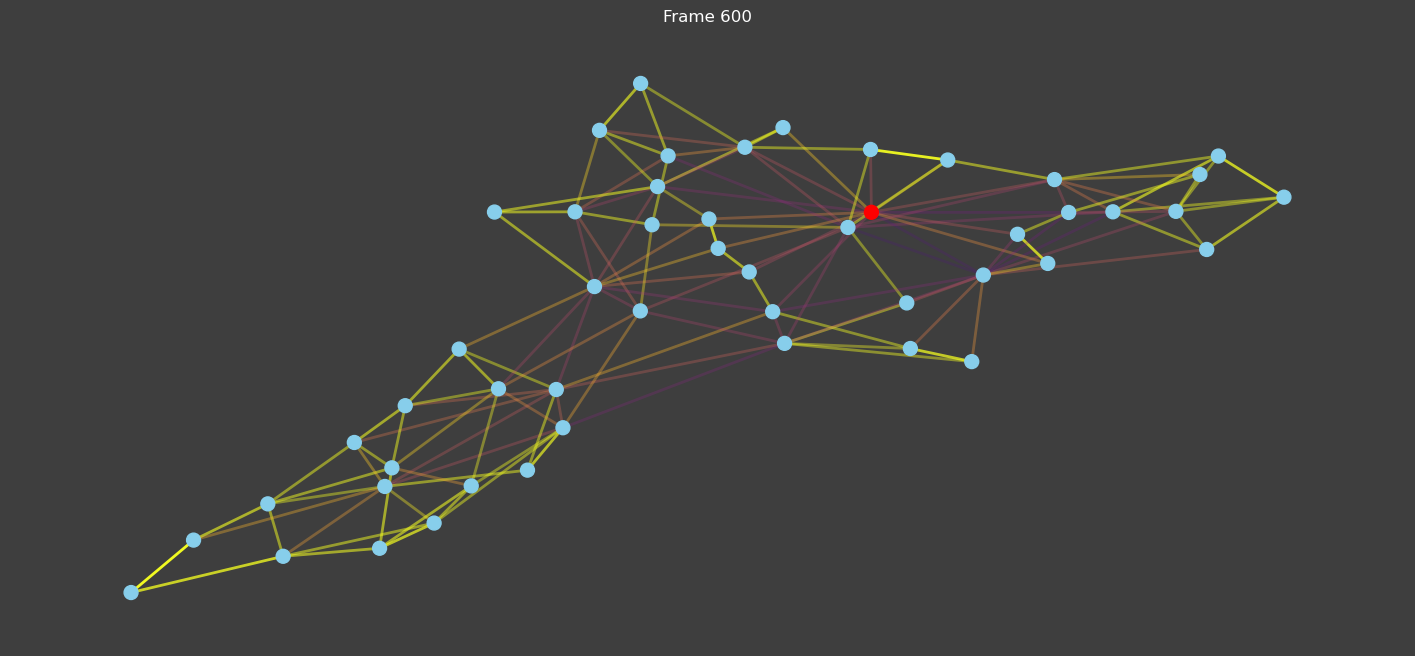

In [79]:
snapshots = multiple_probabilistic_walks(G, num_walks=10, steps=600)
animate_walks(snapshots,  filename="pageRanke_KMJ_smaller.gif",fps=30)

In [84]:
def multiple_probabilistic_walks_betweenness(graph, num_walks, steps):
    walked_edges_per_step = [[] for _ in range(steps)]  # Store walked edges per step
    edge_step_count = {edge: 0 for edge in graph.edges()}  # Track how many times each edge is stepped on
    starting_node = get_highest_degree_node(graph)  # Start walks from the highest degree node
    bc_centralities = nx.betweenness_centrality(graph)
    for _ in range(num_walks):
        current_node = starting_node
        
        for i in range(steps):
            neighbors = list(graph.neighbors(current_node))
            weights = [
                (bc_centralities[neighbor] +0.0000001)
                for neighbor in neighbors
            ]
    
            # Normalize probabilities
            total_weight = sum(weights)
            if total_weight == 0:
                print("Encountered zero total weight")
                break
            
            probabilities = [w / total_weight for w in weights]
    
            next_node = random.choices(neighbors, weights=probabilities)[0]
            edge = (min(current_node, next_node), max(current_node, next_node))

            walked_edges_per_step[i].append(edge)
            edge_step_count[edge] += 1  # Update step count for the edge


            current_node = next_node

    v_graph = copy.deepcopy(graph)
    print(v_graph)
    initialize_edge_weights(v_graph)
    snapshots = []
    for  edges_in_step in walked_edges_per_step:
        for edge in edges_in_step:
            u, v = edge
            v_graph[u][v]['weight'] += 1 
        snapshot = copy.deepcopy(v_graph)
        snapshots.append(snapshot)
        
    
    
    return snapshots 

Graph with 50 nodes and 141 edges
Animation saved as betweenness_KMJ_smaller.gif


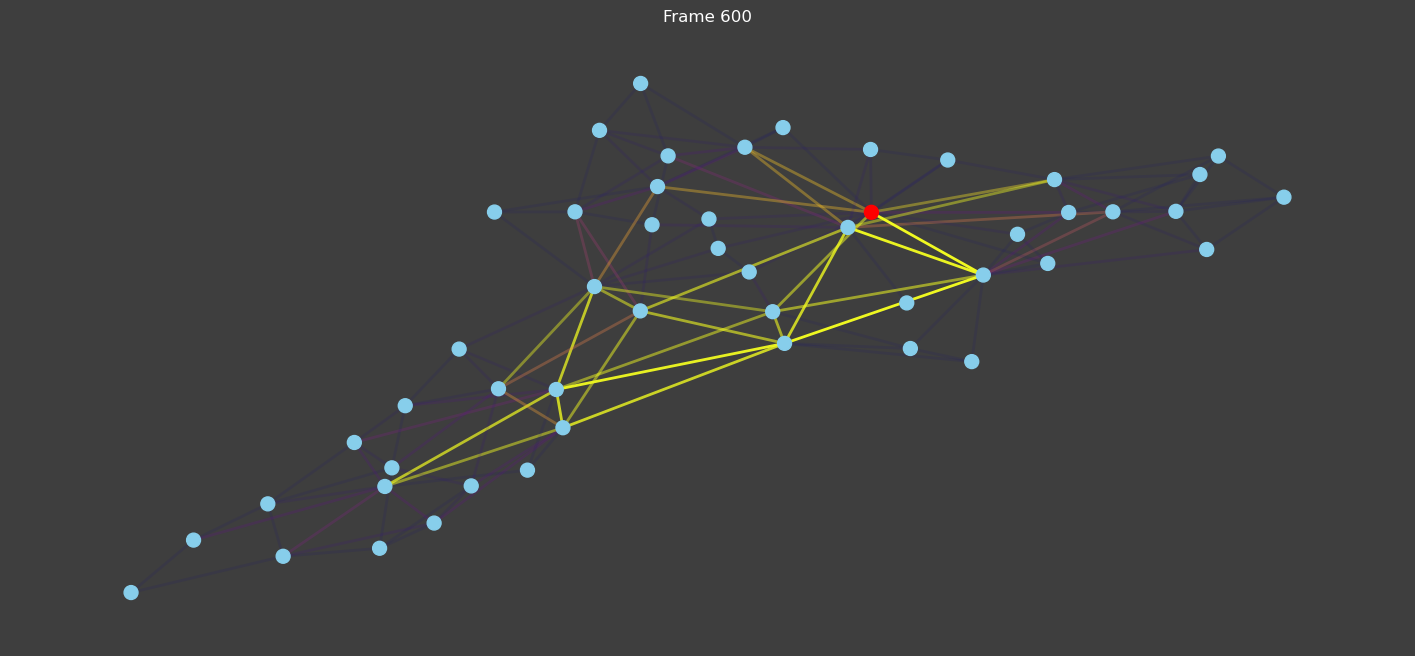

In [85]:
snapshots = multiple_probabilistic_walks_betweenness(G, num_walks=10, steps=600)
animate_walks(snapshots,  filename="betweenness_KMJ_smaller.gif",fps=37)

In [82]:
def multiple_probabilistic_walks_degree(graph, num_walks, steps):
    walked_edges_per_step = [[] for _ in range(steps)]  # Store walked edges per step
    edge_step_count = {edge: 0 for edge in graph.edges()}  # Track how many times each edge is stepped on
    starting_node = get_highest_degree_node(graph)  # Start walks from the highest degree node
    dc_centralities = nx.degree_centrality(graph)
    for _ in range(num_walks):
        current_node = starting_node
        
        for i in range(steps):
            neighbors = list(graph.neighbors(current_node))
            weights = [
                1/(dc_centralities[neighbor])
                for neighbor in neighbors
            ]
    
            # Normalize probabilities
            total_weight = sum(weights)
            if total_weight == 0:
                print("Encountered zero total weight")
                break
            
            probabilities = [w / total_weight for w in weights]
    
            next_node = random.choices(neighbors, weights=probabilities)[0]
            edge = (min(current_node, next_node), max(current_node, next_node))

            walked_edges_per_step[i].append(edge)
            edge_step_count[edge] += 1  # Update step count for the edge


            current_node = next_node

    v_graph = copy.deepcopy(graph)
    print(v_graph)
    initialize_edge_weights(v_graph)
    snapshots = []
    for  edges_in_step in walked_edges_per_step:
        for edge in edges_in_step:
            u, v = edge
            v_graph[u][v]['weight'] += 1 
        snapshot = copy.deepcopy(v_graph)
        snapshots.append(snapshot)
        
    
    
    return snapshots 

Graph with 50 nodes and 141 edges
Animation saved as degree_KMJ_smaller.gif


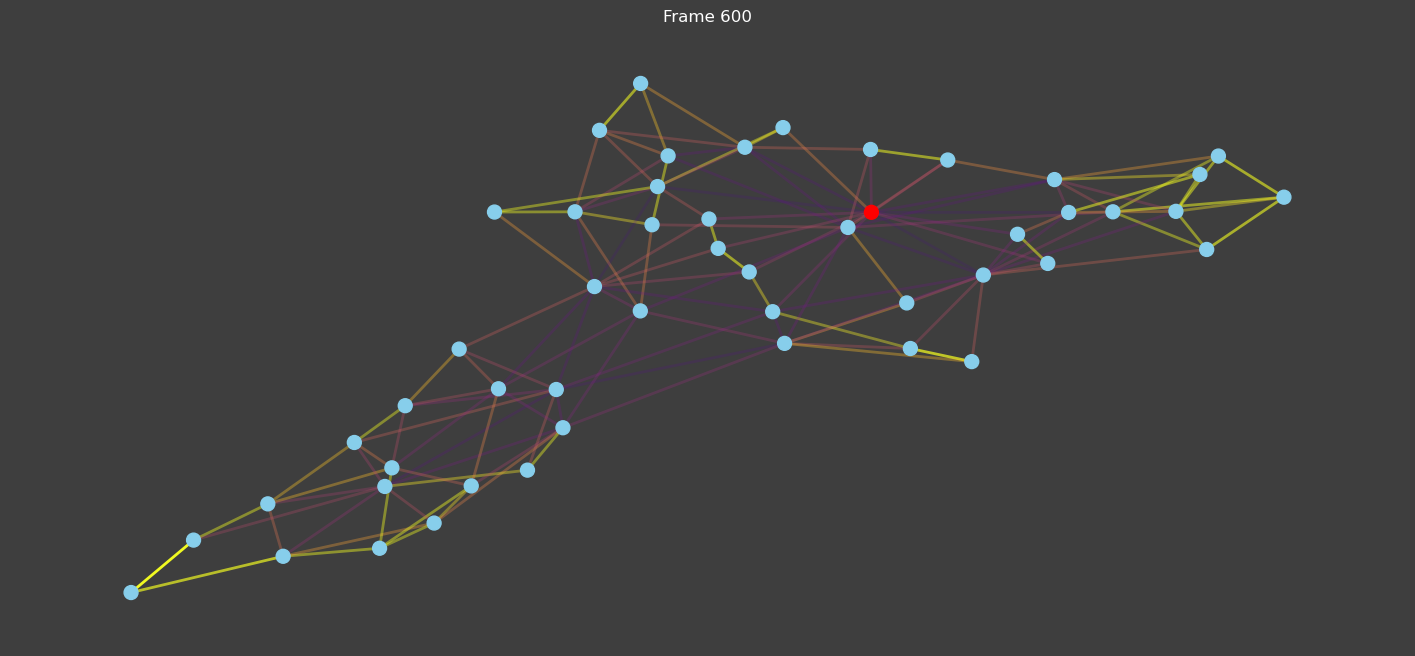

In [83]:
snapshots = multiple_probabilistic_walks_degree(G, num_walks=10, steps=600)
animate_walks(snapshots,  filename="degree_KMJ_smaller.gif",fps=30)

In [89]:
def normalize_dict_values(centrality_dict):
    total = sum(centrality_dict.values())
    return {node: value / total for node, value in centrality_dict.items()}

In [97]:
def multiple_probabilistic_walks_combined(graph, num_walks, steps, alpha_degree=1.0, alpha_pagerank=1.0, alpha_between=1.0):
    walked_edges_per_step = [[] for _ in range(steps)]  # Store walked edges per step
    edge_step_count = {edge: 0 for edge in graph.edges()}  # Track how many times each edge is stepped on

    # Compute centrality measures
    dc_centralities = nx.degree_centrality(graph)
    pagerank_scores = nx.pagerank(graph)
    between_centralities = nx.betweenness_centrality(graph)
    
    dc_centralities = normalize_dict_values(dc_centralities)
    pagerank_scores = normalize_dict_values(pagerank_scores)
    between_centralities = normalize_dict_values(between_centralities)

    starting_node = get_highest_degree_node(graph)  # Start from highest degree node

    for _ in range(num_walks):
        current_node = starting_node
        
        for i in range(steps):
            neighbors = list(graph.neighbors(current_node))
            weights = []
            
            for neighbor in neighbors:
                combined_score = alpha_degree * dc_centralities[neighbor] + alpha_pagerank * pagerank_scores[neighbor]
                between = alpha_between * between_centralities[neighbor] 
                if combined_score != 0:
                    weights.append(1 +between / combined_score)
                else:
                    print(combined_score)
                    weights.append(0.0000001)  # Avoid division by zero
            

            # Normalize probabilities
            total_weight = sum(weights)
            if total_weight == 0:
                print("Encountered zero total weight")
                break
            
            probabilities = [w / total_weight for w in weights]

            next_node = random.choices(neighbors, weights=probabilities)[0]
            edge = (min(current_node, next_node), max(current_node, next_node))

            walked_edges_per_step[i].append(edge)
            edge_step_count[edge] += 1  # Update step count for the edge

            current_node = next_node

    # Generate snapshots
    v_graph = copy.deepcopy(graph)
    initialize_edge_weights(v_graph)
    snapshots = []

    for edges_in_step in walked_edges_per_step:
        for edge in edges_in_step:
            u, v = edge
            v_graph[u][v]['weight'] += 1
        snapshot = copy.deepcopy(v_graph)
        snapshots.append(snapshot)

    

    return snapshots

In [98]:
# Define ranges for alpha_degree and alpha_pagerank
alpha_degree_range = np.linspace(start = -10, stop=11,num=20)  # Adjust the range and step size as needed
alpha_pagerank_range = np.linspace(start = -10, stop=11,num=20)
alpha_betweenness_range = np.linspace(start = -10, stop=11,num=20)
steps = 300

In [99]:
std_devs = []
graph = KMJ(60, normal_distribution, 1000, 180,3000)  # Generate a scale-free graph
print(graph)


# Iterate over combinations of alpha_degree and alpha_pagerank
for alpha_d in alpha_degree_range:
    for alpha_p in alpha_pagerank_range:
        for alpha_b in alpha_betweenness_range:
            graph_copy = copy.deepcopy(graph)  # Work on a fresh copy of the graph
    
            # Modify edge weights dynamically
            
            # Run the probabilistic walk
            snapshots = multiple_probabilistic_walks_combined(graph_copy, 15, steps,alpha_degree=alpha_d,alpha_pagerank=alpha_p,alpha_between=alpha_b)
            final_snapshot = snapshots[-1]  # Snapshot after 400 steps
            
            # Compute standard deviation of edge weights
            edge_weights = [final_snapshot[u][v]['weight'] for u, v in final_snapshot.edges()]
            std_dev = np.std(edge_weights)
            print("d: ",alpha_d,"p: ", alpha_p,"b: ",alpha_b)
            # Store results
            std_devs.append((alpha_d, alpha_p, alpha_b, std_dev))

Graph with 60 nodes and 171 edges
d:  -10.0 p:  -10.0 b:  -10.0
d:  -10.0 p:  -10.0 b:  -8.894736842105264
d:  -10.0 p:  -10.0 b:  -7.789473684210526
d:  -10.0 p:  -10.0 b:  -6.684210526315789
d:  -10.0 p:  -10.0 b:  -5.578947368421052
d:  -10.0 p:  -10.0 b:  -4.473684210526315
d:  -10.0 p:  -10.0 b:  -3.3684210526315788
d:  -10.0 p:  -10.0 b:  -2.2631578947368416
d:  -10.0 p:  -10.0 b:  -1.1578947368421044
d:  -10.0 p:  -10.0 b:  -0.05263157894736814
d:  -10.0 p:  -10.0 b:  1.05263157894737
d:  -10.0 p:  -10.0 b:  2.157894736842106
d:  -10.0 p:  -10.0 b:  3.2631578947368425
d:  -10.0 p:  -10.0 b:  4.3684210526315805
d:  -10.0 p:  -10.0 b:  5.473684210526317
d:  -10.0 p:  -10.0 b:  6.578947368421055
d:  -10.0 p:  -10.0 b:  7.684210526315791
d:  -10.0 p:  -10.0 b:  8.789473684210527
d:  -10.0 p:  -10.0 b:  9.894736842105264
d:  -10.0 p:  -10.0 b:  11.0
d:  -10.0 p:  -8.894736842105264 b:  -10.0
d:  -10.0 p:  -8.894736842105264 b:  -8.894736842105264
d:  -10.0 p:  -8.894736842105264 b:  

In [100]:
alpha_degree_vals, alpha_pagerank_vals,alpha_betweenness_vals, std_dev_vals = zip(*std_devs)
std_dev_array = np.array(std_dev_vals)

# Find the index of the minimum standard deviation
min_index = np.argmin(std_dev_array)
max_index = np.argmax(std_dev_array)

# Retrieve the corresponding parameters
min_alpha_degree = alpha_degree_vals[min_index]
min_alpha_pagerank = alpha_pagerank_vals[min_index]
min_alpha_betweenness = alpha_betweenness_vals[min_index]
min_std_dev = std_dev_array[min_index]

max_alpha_degree = alpha_degree_vals[max_index]
max_alpha_pagerank = alpha_pagerank_vals[max_index]
max_std_dev = std_dev_array[max_index]


# Output the results
print(f"Minimum Standard Deviation: {min_std_dev}")
print(f"Parameters at Minimum: alpha_degree = {min_alpha_degree}, alpha_pagerank = {min_alpha_pagerank} alpha_betweenness = {min_alpha_betweenness}")

Minimum Standard Deviation: 5.4477568582021005
Parameters at Minimum: alpha_degree = -2.2631578947368416, alpha_pagerank = -10.0 alpha_betweenness = -0.05263157894736814


Animation saved as combined_KMJ_smaller.gif


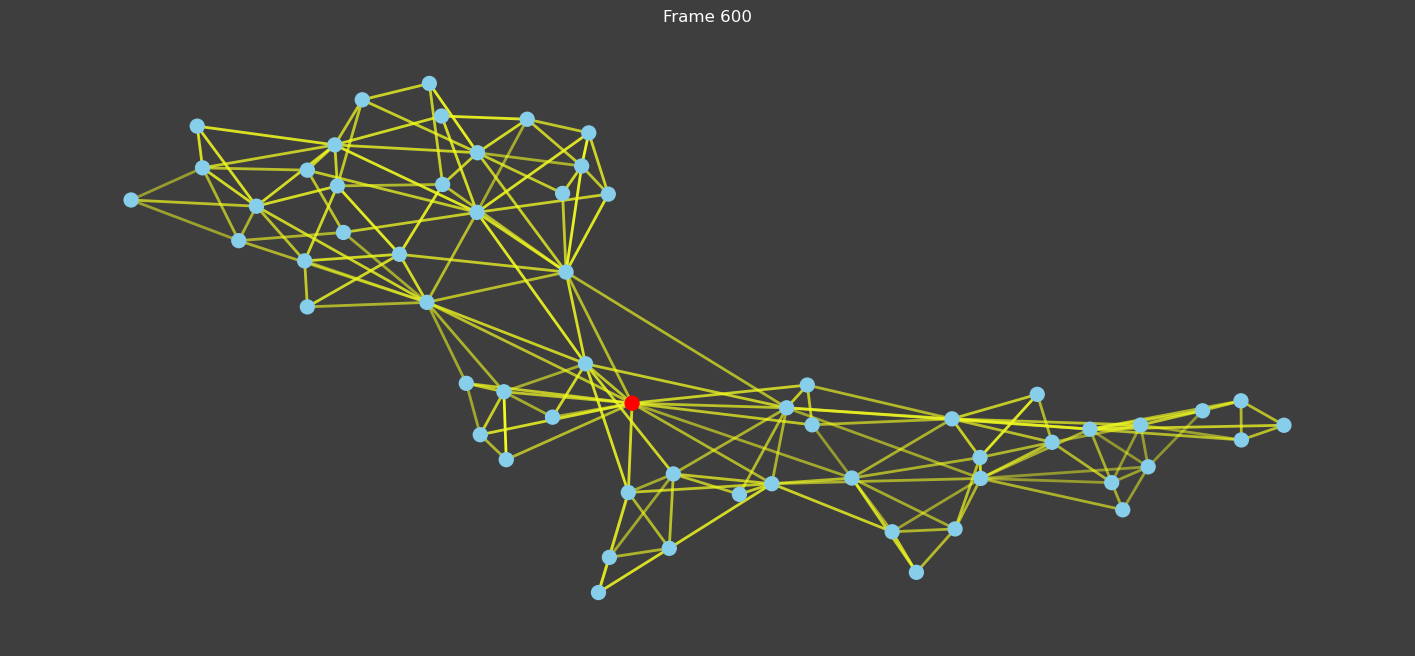

In [101]:
snapshots = multiple_probabilistic_walks_combined(graph,  15, 600,alpha_degree=-2.25,alpha_pagerank=-10,alpha_between=-0.05)
animate_walks(snapshots,  filename="combined_KMJ_smaller.gif",fps=37)

In [102]:
def multiple_probabilistic_walks_uniform(graph, num_walks, steps):
    walked_edges_per_step = [[] for _ in range(steps)]  # Store walked edges per step
    edge_step_count = {edge: 0 for edge in graph.edges()}  # Track how many times each edge is stepped on
    starting_node = get_highest_degree_node(graph)  # Start walks from the highest degree node
    
    for _ in range(num_walks):
        current_node = starting_node
        
        for i in range(steps):
            neighbors = list(graph.neighbors(current_node))
            
    
            # Normalize probabilities
            total_weight = len(neighbors)
            if total_weight == 0:
                print("Encountered zero total weight")
                break
            
            probabilities = [1 / total_weight for w in neighbors]
    
            next_node = random.choices(neighbors, weights=probabilities)[0]
            edge = (min(current_node, next_node), max(current_node, next_node))

            walked_edges_per_step[i].append(edge)
            edge_step_count[edge] += 1  # Update step count for the edge


            current_node = next_node

    v_graph = copy.deepcopy(graph)
    print(v_graph)
    initialize_edge_weights(v_graph)
    snapshots = []
    for  edges_in_step in walked_edges_per_step:
        for edge in edges_in_step:
            u, v = edge
            v_graph[u][v]['weight'] += 1 
        snapshot = copy.deepcopy(v_graph)
        snapshots.append(snapshot)
        
    
    
    return snapshots 

In [119]:
Combined = copy.deepcopy(graph)
Uniform = copy.deepcopy(graph)



snapshots_Uniform = multiple_probabilistic_walks_uniform(Uniform, 250, 3000)
snapshots_Combined = multiple_probabilistic_walks_combined(Combined,  250, 3000,alpha_degree=-2.25,alpha_pagerank=-10,alpha_between=-0.05)

Graph with 60 nodes and 171 edges


In [120]:
def compute_std_devs(snapshots):
    std_devs = []
    for snapshot in snapshots:
        # Extract edge weights
        weights = np.array([snapshot[u][v]['weight'] for u, v in snapshot.edges()])
        std_devs.append(np.std(weights))
    return std_devs

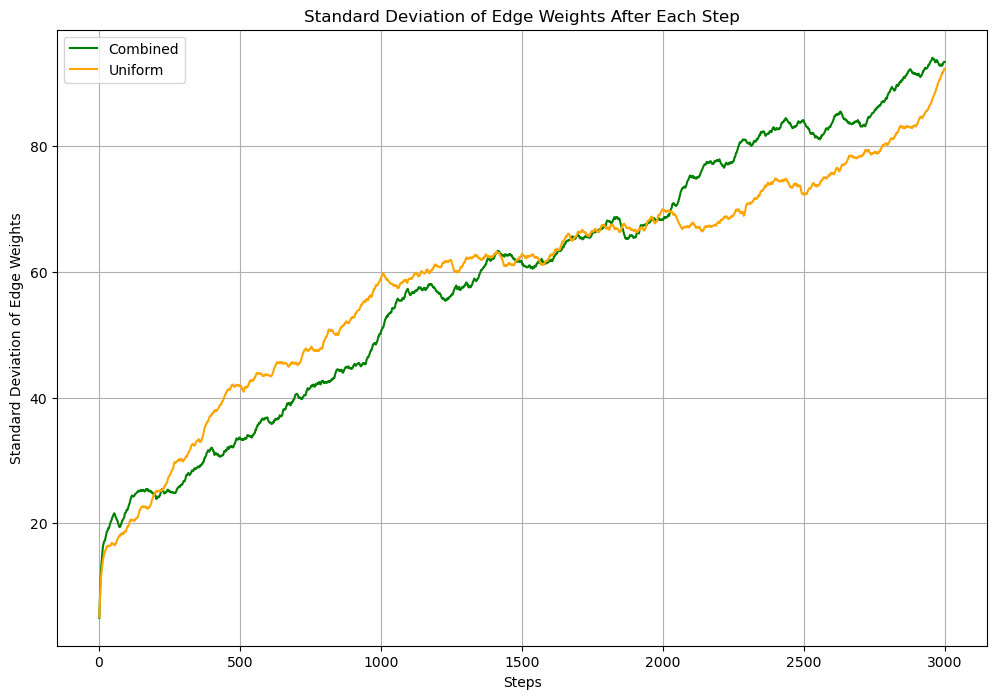

In [121]:

std_devs_Combined = compute_std_devs(snapshots_Combined)
std_devs_Uniform = compute_std_devs(snapshots_Uniform)
# Plotting the standard deviations
plt.figure(figsize=(12, 8))
steps = range(1, 3001)  # Adjust for the number of steps

plt.plot(steps, std_devs_Combined, label='Combined', linestyle='-', color='g')
plt.plot(steps, std_devs_Uniform, label='Uniform', linestyle='-', color='orange')
#plt.plot(steps, std_devs_Between, label='Betweenness', linestyle='-', color='orange')
#plt.plot(steps, std_devs_Max, label='Max', linestyle='-', color='black')

# Add labels and title
plt.xlabel('Steps')
plt.ylabel('Standard Deviation of Edge Weights')
plt.title('Standard Deviation of Edge Weights After Each Step')
plt.legend()
plt.grid()
plt.show()